# 7.4.EfficientNetB7_from_Scratch

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Creando el modelo

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from imutils import paths
import numpy as np
import os

In [3]:
img_size = 224
path_train = 'data_' + str(img_size) + '/train'
path_validation = 'data_' + str(img_size) + '/validation'
path_checkpoints = 'checkpoint_EfficientNetB7'

In [4]:
imagePaths_train = list(paths.list_images(path_train))
imagePaths_validation = list(paths.list_images(path_validation))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths_train]
classNames = [str(x) for x in np.unique(classNames)]

print("etiquetas del entrenamiento")
print(classNames)

#Códificando las etiquetas en númerops
print("codificando etiquetas")
le = LabelEncoder()
classNames_ids = le.fit_transform(classNames)
print(classNames_ids)

etiquetas del entrenamiento
['10', '100', '20', '200', '50']
codificando etiquetas
[0 1 2 3 4]


In [5]:
input_shape = (img_size, img_size, 3)
model = EfficientNetB7(include_top=True,
                            weights=None,
                            input_shape=input_shape,
                            pooling='max',
                            classifier_activation='softmax',
                            classes=len(classNames_ids))

In [6]:
for layer in model.layers:
    layer.trainable = True

In [7]:
model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

# Entrenamiento

In [18]:
batch_size = 8

In [19]:
generator = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
train_generator = generator.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                subset='training')
validation_generator = generator.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                subset='validation')

Found 3930 images belonging to 5 classes.
Found 981 images belonging to 5 classes.


In [20]:
optimizer = SGD(learning_rate=0.0001, momentum=0.9)

loss = 'categorical_crossentropy'
metrics=["accuracy"]

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [23]:
fname = os.path.sep.join([path_checkpoints, 
                          'epoch-{epoch:03d}-val_loss:{val_loss:.4f}-val_accuracy:{val_accuracy:.4f}.hdf5'])
checkpoint = ModelCheckpoint(fname,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)
callbacks = [checkpoint]
#callbacks = []

In [24]:
epochs = 10

history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=validation_generator,
                              epochs = epochs,
                              callbacks=callbacks,
                              verbose = 1)

Epoch 1/10
492/492 [==============================] - ETA: 0s - loss: 3.8003 - accuracy: 0.2109
Epoch 00001: val_loss improved from inf to 40.87740, saving model to checkpoint_EfficientNetB7/epoch-001-val_loss:40.8774-val_accuracy:0.2243.hdf5
492/492 [==============================] - 167s 339ms/step - loss: 3.8003 - accuracy: 0.2109 - val_loss: 40.8774 - val_accuracy: 0.2243
Epoch 2/10
492/492 [==============================] - ETA: 0s - loss: 3.7558 - accuracy: 0.2120
Epoch 00002: val_loss improved from 40.87740 to 24.25908, saving model to checkpoint_EfficientNetB7/epoch-002-val_loss:24.2591-val_accuracy:0.2436.hdf5
492/492 [==============================] - 167s 339ms/step - loss: 3.7558 - accuracy: 0.2120 - val_loss: 24.2591 - val_accuracy: 0.2436
Epoch 3/10
492/492 [==============================] - ETA: 0s - loss: 3.6615 - accuracy: 0.2158
Epoch 00003: val_loss did not improve from 24.25908
492/492 [==============================] - 166s 337ms/step - loss: 3.6615 - accuracy: 0.2

# Gráfica

In [25]:
import matplotlib.pyplot as plt

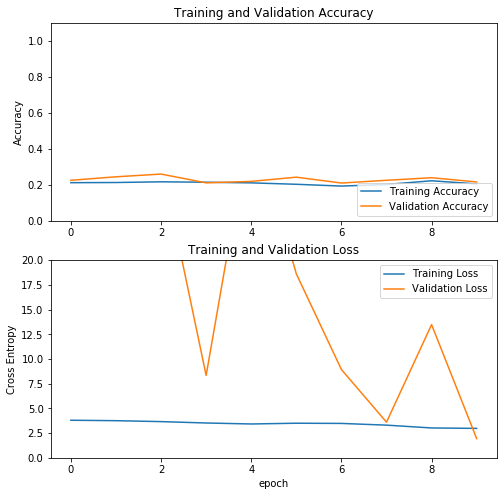

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,20])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Testing model

In [27]:
from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

INFO:tensorflow:Load image with size: 2671, num_label: 5, labels: 10, 100, 20, 200, 50.


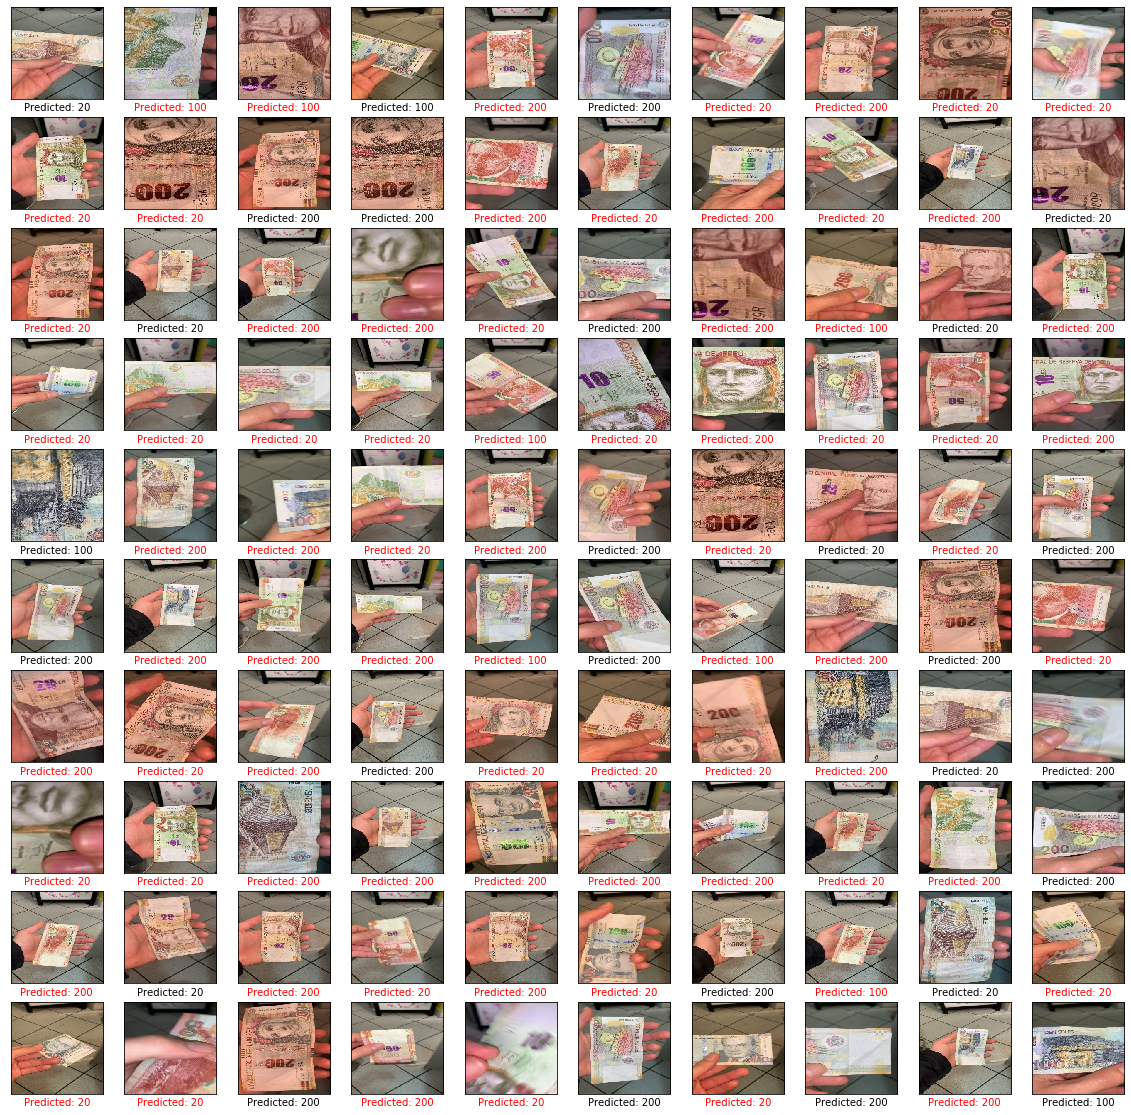

In [28]:
test_data = ImageClassifierDataLoader.from_folder(path_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    
    # predict
    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    id_predict = np.argmax(model.predict(arr4d))
    predict_label = classNames[id_predict]
    
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    #color = 'black'
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()